In [1]:
 !pip install -U scikit-learn==1.4.2 imbalanced-learn==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 데이터 이해와 탐색
## 데이터 불러오기

In [3]:
train = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/train.csv")
test = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/test.csv")

## 데이터 확인하기

* 데이터 칼럼에 대한 특징

1. id : 각 행의대한 고유값으로 고객 id로 유추해 볼 수 있겠습니다.
2. time : 거래 발생시간으로 처음 거래가 발생한 시점을 기준으로 초 단위 경과 시간입니다.
3. v(n) : 정확하게 피처의 의미를 알수는 없지만 데이터를 개인정보 보호를 위해 변환된 값들이며 숫자형 피처입니다.
4. Amount : 실제 거래금액
5. Class : 타킷 변수로 0은 정상거래 1은 사기거래를 의미합니다. train 데이터에만 있습니다.

가장 큰 특징은 **개인정보 보호를 위해 민감한 정보를 보호하기 위해 익명화 되어있다는 점**입니다.

---
    
* 데이터의 전체적인 특징
  
**데이터의 전체적인 특징을 보기위해 head(),info(),describe() 를 확인했습니다.**

1. null값 없습니다.
2. Amount에서 min, max 차이가 크다는것
3. train 데이터에서 사기거래 데이터가 75%이상이여도 나타나지 않다가 max값에서 나타나는것을 보았을 때,    
   사기거래 데이터가 적을 수도 있겠다라는 생각이 들었습니다.

In [4]:
# Train 데이터 확인하기
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Test 데이터 확인하기
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Train info()확인하기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [7]:
# Test info()확인하기
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113923 entries, 0 to 113922
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      113923 non-null  int64  
 1   Time    113923 non-null  float64
 2   V1      113923 non-null  float64
 3   V2      113923 non-null  float64
 4   V3      113923 non-null  float64
 5   V4      113923 non-null  float64
 6   V5      113923 non-null  float64
 7   V6      113923 non-null  float64
 8   V7      113923 non-null  float64
 9   V8      113923 non-null  float64
 10  V9      113923 non-null  float64
 11  V10     113923 non-null  float64
 12  V11     113923 non-null  float64
 13  V12     113923 non-null  float64
 14  V13     113923 non-null  float64
 15  V14     113923 non-null  float64
 16  V15     113923 non-null  float64
 17  V16     113923 non-null  float64
 18  V17     113923 non-null  float64
 19  V18     113923 non-null  float64
 20  V19     113923 non-null  float64
 21  V20     11

In [8]:
# Train describe()확인하기
train.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [9]:
# Test describe()확인하기
test.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,...,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000,113923.000000
mean,227844.000000,145396.169808,0.254759,-0.061154,-0.739555,-0.176137,0.264150,-0.087346,0.120988,-0.048337,...,-0.046430,0.042428,0.125609,0.033672,-0.013512,-0.138398,-0.018897,-0.003140,-0.003667,89.867850
std,32886.881696,14553.200321,2.084808,1.708359,1.402141,1.461789,1.399511,1.381543,1.269186,1.140927,...,0.831851,0.718441,0.788888,0.678614,0.615591,0.567769,0.468657,0.420530,0.361528,256.236008
min,170883.000000,120396.000000,-46.855047,-50.383269,-48.325589,-5.683171,-113.743307,-20.869626,-23.386192,-39.688571,...,-54.497720,-21.620120,-7.417140,-36.666000,-2.790479,-8.696627,-1.855355,-9.895244,-15.430084,0.000000
25%,199363.500000,132928.500000,-0.803531,-0.691506,-1.598860,-0.978315,-0.437285,-0.880171,-0.491675,-0.273015,...,-0.247537,-0.223898,-0.534543,-0.142571,-0.382480,-0.450968,-0.313872,-0.075609,-0.062317,5.950000
50%,227844.000000,145247.000000,0.117889,-0.005846,-0.734520,-0.337083,0.250458,-0.389808,0.153525,-0.035902,...,-0.104920,0.036139,0.186973,0.040791,0.016358,-0.193153,-0.041566,-0.009555,-0.028507,22.450000
75%,256324.500000,157639.500000,1.978707,0.803286,0.121444,0.431529,0.882923,0.309498,0.746755,0.285891,...,0.091959,0.253758,0.750595,0.227957,0.524460,0.221885,0.214766,0.093824,0.078238,78.000000
max,284805.000000,172788.000000,2.454930,12.730564,3.937048,15.304184,29.162172,73.301626,120.589494,12.766112,...,23.643417,20.063786,8.272233,22.528412,4.584549,6.070850,3.415636,31.612198,16.129609,25691.160000


## 데이터 시각화

* 데이터를 시각화하여 데이터의 특징을 더 명확하게 살펴보겠습니다.

  1. train 데이터의 Class 정상거래와 사기거래 비율 확인하기
  2. 사기 거래와 정상 거래의 금액 분포 확인하기
  3. Amount와 Class의 상관관계를 heatmap으로 살펴보기
  4. Class와 V1 ~ V28의 상관관계 Heatmap으로 살펴보기

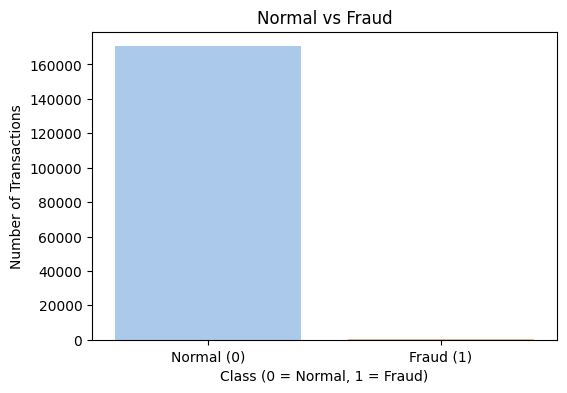

In [10]:
# train 데이터의 Class 정상거래와 사기거래 비율을 그래프로 시각화 하여 확인하겠습니다.
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='Class', palette='pastel')

plt.title('Normal vs Fraud') # 정상거래 vs 사기거래
plt.xlabel('Class (0 = Normal, 1 = Fraud)')
plt.ylabel('Number of Transactions') #거래건수
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

* 그래프로 확인해본결과 정상거래가 훨씬 더 많이 존재하고 있습니다.
* 사기거래는 데이터에서 아주 작은 부분을 차지하고 있어 불균형한 분포를 가지고 있다는것을 알 수 있습니다.

In [11]:
# 정확한 데이터 갯수를 확인해 보겠습니다.
print(train['Class'].value_counts())

Class
0    170523
1       360
Name: count, dtype: int64


In [12]:
#Class 컬럼의 각 값(0: 정상 거래, 1: 사기 거래)의 비율(%)도 살펴보겠습니다.
train["Class"].value_counts(normalize=True)*100

Class
0    99.78933
1     0.21067
Name: proportion, dtype: float64

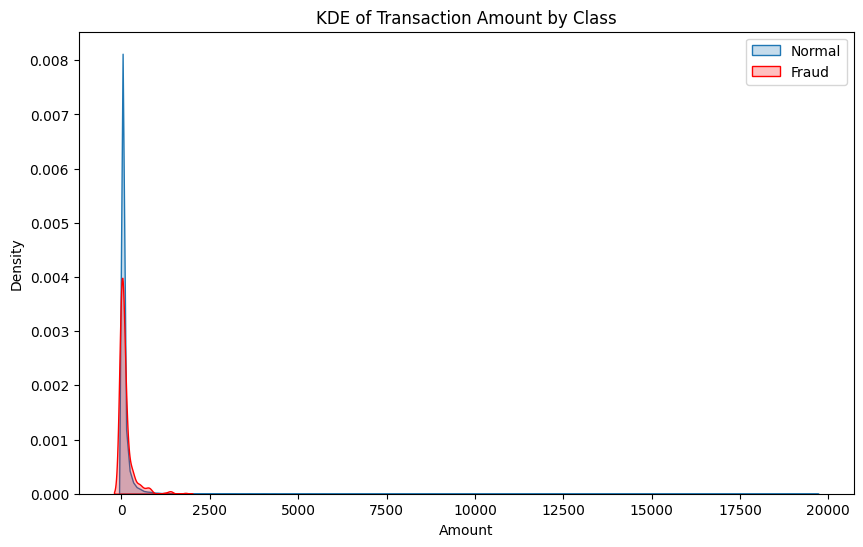

In [13]:
# 사기 거래와 정상 거래의 금액 분포 확인하기
plt.figure(figsize=(10, 6))
sns.kdeplot(train[train['Class'] == 0]['Amount'], label='Normal', fill=True)
sns.kdeplot(train[train['Class'] == 1]['Amount'], label='Fraud', fill=True, color='red')

plt.title('KDE of Transaction Amount by Class')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

* 작은 금액의 거래 비중이 높고 큰 금액의 거래는 상대적으로 적은 비중을 차지 하고 있으며 금액에서도 분포의 편차가 큰것으로 확인됩니다.
* 대부분 소액 거래에 집중되어 있으며 사기 거래 또한 대부분 작은 금액으로 이루어져 있는것을 확인할 수 있습니다.
* 결론적으로 사기 거래가 정상 거래보다 금액이 항상 크거나 다른 특징을 가지고 있지 않다는것을 알 수 있습니다.

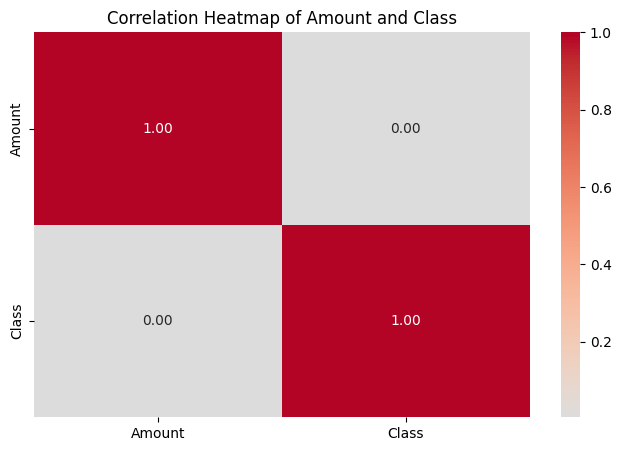

In [14]:
#Amount와 Class의 상관관계를 heatmap으로 살펴보기

# Amount와 Class만 선택해서 상관계수 계산
corr_matrix = train[['Amount', 'Class']].corr()

# 히트맵 그리기
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)

plt.title("Correlation Heatmap of Amount and Class")
plt.show()

* 결론적으로 Amount와 Class간 뚜렷한 상관관계가 없으며
* 두 정보만으로는 사기 거래 여부를 잘 구분하지 못한다는 것을 알 수 있습니다.

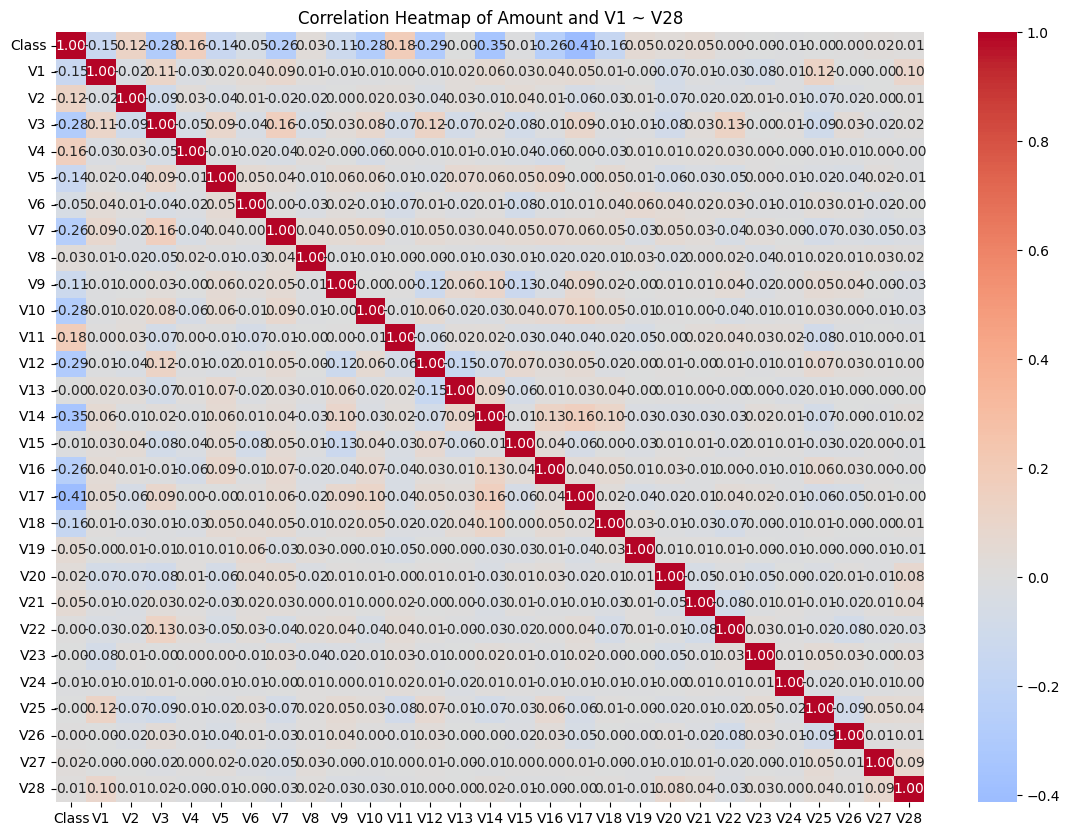

In [15]:
# Class와 V1 ~ V28의 상관관계 Heatmap 그리기

# V1 ~ V28과 Amount만 선택
features = ['Class'] + [f'V{i}' for i in range(1, 29)]
df_corr = train[features]

corr_matrix = df_corr.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Amount and V1 ~ V28")
plt.show()

* 히트맵으로 Class와 V1~V28의 상관관계를 보았을때 V14와 V17이 상관관계가 높다는 것을 알 수 있습니다.
* 상관관계가 높다는것은 이상치가 있을 때 학습 데이터를 왜곡할 수 있기 때문에 V14와 V17의 이상치를 제거해주도록 하겠습니다.

# 학습/예측/평가 하기
## 모델 학습/예측/평가 하기

* Time의 경우 모델을 만드는데 중요한 칼럼이 아니기에 제거하도록 하겠습니다.
* Amount는 꼬리가 긴 분포를 가지고있지만 중요한 지표로써 표준 정규 분포 형태로 변환한하여 성능을 측정해 보겠습니다.
* id 칼럼의 경우도 모델을 만드는데 필요없는 칼럼이라고 생각하여 제거하도록 하겠습니다.
* 위에서 확인했을 때 V14, V17의 상관관계가 높게 발생했기 때문에 두 지표의 이상치를 처리하여 성능을 측정해 보겠습니다.

In [16]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [17]:
# 이상치 탐지 함수 정의
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

* 이상치를 찾아내기 위한 함수를 정의하였습니다.
* 박스플롯 방식(IQR 방법)으로 이상치를 탐지하여 해당 데이터의 인덱스를 변수에 담았습니다.
* 특히 'Class'가 1인 사기 거래들 중에서도 특이한 패턴을 보이는 거래를 식별합니다.

In [18]:
# 전처리 함수 (id 제거 포함)
def get_preprocessed_df_case3(df):
    df_copy = df.copy()
    
    if 'id' in df_copy.columns:
        df_copy.drop('id', axis=1, inplace=True)
    scaler = StandardScaler()
    amount_scaled = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    df_copy.insert(0, 'Amount_Scaled', amount_scaled)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    outlier_index_v14 = get_outlier(df_copy, column='V14')
    outlier_index_v17 = get_outlier(df_copy, column='V17')
    outlier_index = list(set(outlier_index_v14).union(set(outlier_index_v17)))
    df_copy.drop(index=outlier_index, inplace=True)
    
    return df_copy

* 데이터 전처리를 위한 함수를 정의하였습니다.
* 불필요한 'id' 컬럼을 제거하고, 'Amount' 변수는 표준화(StandardScaler)하여 새로운 'Amount_Scaled' 컬럼으로 추가하였습니다.
* 분석에 불필요한 'Time'과 원본 'Amount' 컬럼을 제거하였습니다.
* V14와 V17 변수에서 이상치를 탐지하고, 두 변수에서 발견된 이상치의 합집합을 구하여 해당 데이터를 제거하였습니다.

In [19]:
# 학습/테스트 데이터 분리 함수
def get_train_test_dataset(df):
    df_copy = get_preprocessed_df_case3(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size=0.3,
                                                        stratify=y_target,
                                                        random_state=0)
    
    return X_train, X_test, y_train, y_test

* 학습 및 테스트 데이터셋을 분리하는 함수를 정의하였습니다.
* 앞서 정의한 전처리 함수 **(get_preprocessed_df_case3)** 를 통해 데이터를 먼저 전처리합니다.
* 전처리된 데이터에서 특성(features)과 타겟 변수를 분리합니다.
* train_test_split 함수를 사용하여 데이터를 7:3 비율로 학습/테스트 세트로 분할하였습니다.
* 클래스 불균형 문제를 고려하여 stratify 파라미터를 적용함으로써 원본 데이터의 클래스 비율이 학습/테스트 세트에서도 유지되도록 하였습니다.

In [20]:
# 평가 함수
def get_clf_eval(y_test, pred, pred_proba=None): 
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1스코어: {f1:.4f}, roc-auc: {roc_auc:.4f}")

* 모델 성능 평가를 위한 함수를 정의하였습니다.
* 여러 평가 지표를 한번에 계산하여 출력합니다

    * 오차 행렬(confusion matrix)을 통해 실제 클래스와 예측 클래스의 분포를 확인합니다.
    * 정확도(accuracy), 정밀도(precision), 재현율(recall), F1 스코어를 계산하여 모델의 성능을 다각도로 분석합니다.
    * ROC-AUC 점수도 함께 계산하여 모델의 분류 성능을 평가합니다.

* 특히 사기 탐지와 같은 불균형 데이터셋에서 중요한 정밀도, 재현율, F1 스코어, ROC-AUC 값을 모두 고려하여 종합적인 평가가 가능하도록 설계하였습니다.

In [21]:
# 모델 학습 및 평가 함수
def get_model_train_eval(model, ftr_train, ftr_test, tgt_train, tgt_test):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

* 모델의 학습과 평가를 한번에 수행하는 함수를 정의하였습니다.
* 입력받은 모델을 학습 데이터(ftr_train, tgt_train)로 훈련시킵니다.
* 학습된 모델을 사용하여 테스트 데이터(ftr_test)에 대한 예측값과 예측 확률값을 계산합니다.
* 앞서 정의한 평가 함수(get_clf_eval)를 호출하여 모델의 성능을 다양한 지표로 평가합니다.
* 이 함수를 사용하면 여러 모델을 동일한 방식으로 쉽게 학습하고 평가할 수 있어, 모델 비교 실험에 효율적입니다.

In [22]:
# 하이퍼파라미터 튜닝 함수
def hyperparameter_tuning(model, params, X, y):
    
    grid = GridSearchCV(model, 
                        param_grid=params, 
                        scoring='roc_auc', 
                        cv=3, 
                        n_jobs=-1, 
                        verbose=1)
    
    grid.fit(X, y)
    print("최적 하이퍼파라미터:", grid.best_params_)
    
    return grid.best_estimator_

* 모델의 하이퍼파라미터 튜닝을 위한 함수를 정의하였습니다.
* GridSearchCV를 사용하여 지정된 파라미터 그리드 내에서 최적의 하이퍼파라미터 조합을 탐색합니다.
* 평가 지표로는 'roc_auc'를 사용하여 불균형 데이터에서도 효과적인 모델을 선택합니다.
* 3-겹 교차 검증(cv=3)을 수행하여 모델의 일반화 성능을 평가합니다.
* 계산 효율성을 위해 모든 가용 CPU 코어를 사용(n_jobs=-1)하도록 설정하였습니다.
* 최적의 하이퍼파라미터를 출력하고, 이를 적용한 최적 모델을 반환하여 후속 분석에 활용할 수 있도록 하였습니다

In [23]:
# 데이터 전처리
X_train, X_test, y_train, y_test = get_train_test_dataset(train)

In [24]:
# SMOTE 적용
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

* 클래스 불균형 문제를 해결하기 위해 SMOTE(Synthetic Minority Over-sampling Technique) 기법을 적용하였습니다.
* **SMOTE는 소수 클래스(사기 거래)의 샘플을 인공적으로 생성하여 클래스 간 균형을 맞추는 오버샘플링 방법**입니다.
* 일관된 결과를 위해 random_state를 0으로 설정하였습니다.
* 학습 데이터(X_train, y_train)에 SMOTE를 적용하여 클래스가 균형잡힌 새로운 데이터셋(X_train_over, y_train_over)을 생성하였습니다.
* 이를 통해 모델이 소수 클래스에 대해서도 충분히 학습할 수 있도록 하여 분류 성능을 향상시킬 수 있습니다.

In [25]:
# 로지스틱 회귀
print("## 로지스틱 회귀 예측 성능 ##")
print("[원본 데이터]")
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print("[SMOTE 데이터]")
lr_clf_smote = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf_smote, X_train_over, X_test, y_train_over, y_test)

print("[하이퍼 파라미터 튜닝 데이터]")
lr_params = {'C': [0.01, 0.1, 1, 10]}
lr_best = hyperparameter_tuning(LogisticRegression(max_iter=1000), lr_params, X_train_over, y_train_over)
get_model_train_eval(lr_best, X_train_over, X_test, y_train_over, y_test)

## 로지스틱 회귀 예측 성능 ##
[원본 데이터]
오차 행렬
[[51145    12]
 [   41    66]]
정확도: 0.9990, 정밀도: 0.8462, 재현율: 0.6168, f1스코어: 0.7135, roc-auc: 0.9666
[SMOTE 데이터]
오차 행렬
[[50129  1028]
 [   10    97]]
정확도: 0.9798, 정밀도: 0.0862, 재현율: 0.9065, f1스코어: 0.1575, roc-auc: 0.9749
[하이퍼 파라미터 튜닝 데이터]
Fitting 3 folds for each of 4 candidates, totalling 12 fits
최적 하이퍼파라미터: {'C': 10}
오차 행렬
[[50123  1034]
 [   10    97]]
정확도: 0.9796, 정밀도: 0.0858, 재현율: 0.9065, f1스코어: 0.1567, roc-auc: 0.9749


* 로지스틱 회귀 모델을 사용하여 사기 탐지를 수행하고, 세 가지 접근 방식으로 성능을 비교하였습니다.
* 첫째, 원본 학습 데이터를 사용하여 모델을 학습하고 평가하였습니다. 최대 반복 횟수(max_iter)는 수렴을 보장하기 위해 1000으로 설정하였습니다.
* 둘째, SMOTE를 적용하여 클래스 균형을 맞춘 데이터로 모델을 학습하고 평가하였습니다.
* 셋째, SMOTE 적용 데이터에 추가로 하이퍼파라미터 튜닝을 수행하였습니다. 규제 강도를 조절하는 C 파라미터에 대해 다양한 값(0.01, 0.1, 1, 10)을 탐색하여 최적의 모델을 찾았습니다.
* 세 가지 접근 방식에 대한 성능 평가 결과를 비교함으로써, 클래스 불균형 처리와 하이퍼파라미터 튜닝이 모델 성능에 미치는 영향을 분석할 수 있습니다.

In [26]:
# LightGBM
print("\n## LightGBM 예측 성능 ##")
print("[원본 데이터]")
lgbm_clf = LGBMClassifier(boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

print("[SMOTE 데이터]")
lgbm_clf_smote = LGBMClassifier(boost_from_average=False)
get_model_train_eval(lgbm_clf_smote, X_train_over, X_test, y_train_over, y_test)

print("[하이퍼 파라미터 튜닝 데이터]")
lgbm_params = {'num_leaves': [31, 64], 'n_estimators': [200, 500], 'learning_rate': [0.01, 0.1]}
lgbm_best = hyperparameter_tuning(LGBMClassifier(boost_from_average=False), lgbm_params, X_train_over, y_train_over)
get_model_train_eval(lgbm_best, X_train_over, X_test, y_train_over, y_test)


## LightGBM 예측 성능 ##
[원본 데이터]
[LightGBM] [Info] Number of positive: 250, number of negative: 119366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 119616, number of used features: 29
오차 행렬
[[51152     5]
 [   16    91]]
정확도: 0.9996, 정밀도: 0.9479, 재현율: 0.8505, f1스코어: 0.8966, roc-auc: 0.9658
[SMOTE 데이터]
[LightGBM] [Info] Number of positive: 119366, number of negative: 119366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 238732, number of used features: 29
오차 행렬
[[51119    38]
 [   17    90]]
정확도: 0.9989, 정밀도: 0.7031, 재현율: 0.8411, f1스코어: 0.7660, roc-auc: 0.9730
[하이퍼 파라미터 튜닝 데이터]
Fi

* LightGBM 알고리즘을 사용하여 사기 탐지 모델을 구현하고, 세 가지 접근 방식으로 성능을 비교하였습니다.
* 모든 LightGBM 모델에서 불균형 데이터 처리를 위해 'boost_from_average=False' 파라미터를 설정하였습니다. 이는 클래스 불균형 상황에서 초기 예측값 계산 방식을 조정하는 옵션입니다.
* 첫째, 원본 학습 데이터를 사용하여 LightGBM 모델을 학습하고 평가하였습니다.
* 둘째, SMOTE를 적용하여 클래스 균형을 맞춘 데이터로 모델을 학습하고 평가하였습니다.
* 셋째, SMOTE 적용 데이터에 추가로 하이퍼파라미터 튜닝을 수행하였습니다. 주요 파라미터인 num_leaves(트리의 최대 잎 노드 수), n_estimators(트리의 개수), learning_rate(학습률)에 대해 다양한 조합을 탐색하였습니다.
* 이를 통해 트리 기반 부스팅 알고리즘인 LightGBM의 사기 탐지 성능과 최적 파라미터 조합을 확인할 수 있습니다.

In [27]:
# XGBoost
print("\n## XGBoost 예측 성능 ##")
print("[원본 데이터]")
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
get_model_train_eval(xgb_clf, X_train, X_test, y_train, y_test)

print("[SMOTE 데이터]")
xgb_clf_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
get_model_train_eval(xgb_clf_smote, X_train_over, X_test, y_train_over, y_test)

print("[하이퍼 파라미터 튜닝 데이터]")
xgb_params = {'n_estimators': [200, 500], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}
xgb_best = hyperparameter_tuning(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, X_train_over, y_train_over)
get_model_train_eval(xgb_best, X_train_over, X_test, y_train_over, y_test)



## XGBoost 예측 성능 ##
[원본 데이터]
오차 행렬
[[51150     7]
 [   17    90]]
정확도: 0.9995, 정밀도: 0.9278, 재현율: 0.8411, f1스코어: 0.8824, roc-auc: 0.9769
[SMOTE 데이터]
오차 행렬
[[51131    26]
 [   15    92]]
정확도: 0.9992, 정밀도: 0.7797, 재현율: 0.8598, f1스코어: 0.8178, roc-auc: 0.9820
[하이퍼 파라미터 튜닝 데이터]
Fitting 3 folds for each of 8 candidates, totalling 24 fits
최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}
오차 행렬
[[51134    23]
 [   15    92]]
정확도: 0.9993, 정밀도: 0.8000, 재현율: 0.8598, f1스코어: 0.8288, roc-auc: 0.9830


* XGBoost 알고리즘을 사용하여 사기 탐지 모델을 구현하고, 세 가지 접근 방식으로 성능을 비교하였습니다.
* 모든 XGBoost 모델에서 'use_label_encoder=False' 옵션을 사용하여 레이블을 자동으로 인코딩하지 않도록 설정하고, 'eval_metric=logloss'를 사용하여 로그 손실 함수로 모델을 평가하였습니다.
* 첫째, 원본 학습 데이터를 사용하여 XGBoost 모델을 학습하고 평가하였습니다.
* 둘째, SMOTE를 적용하여 클래스 균형을 맞춘 데이터로 모델을 학습하고 평가하였습니다.
* 셋째, SMOTE 적용 데이터에 추가로 하이퍼파라미터 튜닝을 수행하였습니다. n_estimators(트리의 개수), learning_rate(학습률), max_depth(트리의 최대 깊이)에 대해 다양한 조합을 탐색하여 최적의 모델을 찾았습니다.
* 이를 통해 또 다른 트리 기반 부스팅 알고리즘인 XGBoost의 사기 탐지 성능과 최적 파라미터 설정을 확인할 수 있습니다.

#### **모든 모델 성능 비교**

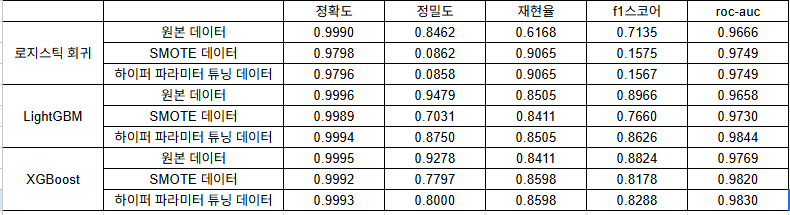

모든 모델의 성능을 표로 제작하여 비교해봤습니다.

## 결론

* 저는 **LightGBM 모델의 하이퍼 파라미터 튜닝 데이터**를 최종 선택하였습니다.
* 선택한 이유

    1. 전체적인 성능 균형이 가장 좋다고 판단했습니다. F1스코어는 정밀도와 재현율의 조화 평균으로 불균형 데이터 문제에서 중요한 지표인데 LightGBM 모델의 하이퍼 파라미터 튜닝 데이터가 다른 경우들보다 높은 수준으로 확인되었습니다.
    2. 정밀도와 재현율 간의 균형이 한쪽으로 치우치지 않은 예측 성능을 보였습니다.
    3. ROC-AUC 점수도 가장 높았습니다. 세 모델중에 가장 높으며 ROC-AUC는 모델의 전체적인 분류 성능을 평가하는 지표로 클래스 불균형 에서도 중요한 판단 기준입니다.

**결론적으로, 튜닝된 LightGBM 모델은 다양한 평가 지표에서 고르게 우수한 성능을 보이며,**    
**특히 F1 스코어와 ROC-AUC 기준에서 최고의 결과를 보여주었기 때문에 최종적으로 선택하게 되었습니다.**

In [28]:
# LightGBM[하이퍼 파라미터 튜닝 데이터]

# test 데이터 불러오기 및 id 따로 저장
test = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/test.csv")
test_id = test["id"]

# 전처리 (Amount_Scaled 만들고, 필요없는 컬럼 제거)
test["Amount_Scaled"] = np.log1p(test["Amount"])
test.drop(["Time", "Amount", "id"], axis=1, inplace=True)

# 훈련 데이터의 컬럼 순서와 동일하게 정렬
test = test[X_train.columns]  # X_train 또는 X_train_over와 컬럼 순서를 맞추는 게 핵심

# 확률이 아닌 0/1 결과로 예측
lgbm_pred = lgbm_best.predict(test)

# 제출 파일 생성
submission = pd.read_csv("/kaggle/input/modu-ds-4-credit-card-fraud-detection/sample_submission.csv")
submission["Class"] = lgbm_pred
submission.to_csv("submission_lgbm_pred.csv", index=False)